In [10]:
# Create a new file: ml_forecasting.py

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import sys

sys.path.insert(0, '/Users/mattthew/Documents/GitHub/Wind_Power_Forcasting/src')
from irish_buoy_data import IrishBuoyData

In [11]:
class BuoyDataset(Dataset):
    """
    Dataset for spatiotemporal buoy data following the framework:
    Input: {S(t), S(t-1), ..., S(t-T+1)} with shape (T, 6, 4)
    Output: S(t+1) with shape (6, 4)
    """
    def __init__(self, data_dict, sequence_length=24, normalize=True):
        """
        Args:
            data_dict: Dictionary mapping buoy_id -> DataFrame
            sequence_length: T in the paper (number of past timesteps)
            normalize: Whether to standardize features
        """
        self.sequence_length = sequence_length
        self.buoy_ids = ['M2', 'M3', 'M4', 'M5', 'M6']
        self.feature_names = [
            'WindSpeed (knots)',
            'AirTemperature (degrees_C)', 
            'AtmosphericPressure (millibars)',
            'WaveHeight (meters)'
        ]
        
        # Align all buoy data to common time grid
        self.aligned_data = self._align_buoy_data(data_dict)
        
        # Standardize features
        if normalize:
            self.scaler = StandardScaler()
            self.aligned_data = self._normalize_data(self.aligned_data)
        else:
            self.scaler = None
        
        # Create samples using sliding window
        self.samples = self._create_samples()
    
    def _align_buoy_data(self, data_dict):
        """Align all buoys to common time grid, interpolate missing values"""
        # Find common time range
        all_indices = []
        for buoy_id in self.buoy_ids:
            if buoy_id in data_dict and len(data_dict[buoy_id]) > 0:
                all_indices.append(data_dict[buoy_id].index)
        
        if not all_indices:
            raise ValueError("No valid buoy data provided")
        
        # Create hourly time grid spanning all data
        start_time = max([idx.min() for idx in all_indices])
        end_time = min([idx.max() for idx in all_indices])
        time_grid = pd.date_range(start=start_time, end=end_time, freq='H')
        
        # Align each buoy to time grid
        aligned = {}
        for buoy_id in self.buoy_ids:
            if buoy_id in data_dict:
                df = data_dict[buoy_id][self.feature_names]
                # Reindex and interpolate
                df_aligned = df.reindex(time_grid)
                df_aligned = df_aligned.interpolate(method='linear', limit=3)
                aligned[buoy_id] = df_aligned.fillna(method='ffill').fillna(method='bfill')
            else:
                # If buoy missing, create zero-filled placeholder
                aligned[buoy_id] = pd.DataFrame(
                    np.zeros((len(time_grid), len(self.feature_names))),
                    index=time_grid,
                    columns=self.feature_names
                )
        
        return aligned
    
    def _normalize_data(self, aligned_data):
        """Standardize each variable across all buoys and time"""
        # Stack all data
        all_values = []
        for buoy_id in self.buoy_ids:
            all_values.append(aligned_data[buoy_id].values)
        stacked = np.vstack(all_values)
        
        # Fit scaler
        self.scaler.fit(stacked)
        
        # Transform each buoy
        normalized = {}
        for buoy_id in self.buoy_ids:
            values = aligned_data[buoy_id].values
            normalized_values = self.scaler.transform(values)
            normalized[buoy_id] = pd.DataFrame(
                normalized_values,
                index=aligned_data[buoy_id].index,
                columns=self.feature_names
            )
        
        return normalized
    
    def _create_samples(self):
        """Create sliding window samples"""
        samples = []
        
        # Get time indices (same for all buoys after alignment)
        time_indices = list(self.aligned_data[self.buoy_ids[0]].index)
        
        # Sliding window
        for i in range(self.sequence_length, len(time_indices) - 1):
            # Input: past T timesteps, shape (T, 6, 4)
            input_sequence = np.zeros((self.sequence_length, len(self.buoy_ids), len(self.feature_names)))
            
            for t_offset in range(self.sequence_length):
                t_idx = i - self.sequence_length + t_offset
                for b_idx, buoy_id in enumerate(self.buoy_ids):
                    input_sequence[t_offset, b_idx, :] = self.aligned_data[buoy_id].iloc[t_idx].values
            
            # Target: next timestep, shape (6, 4)
            target = np.zeros((len(self.buoy_ids), len(self.feature_names)))
            for b_idx, buoy_id in enumerate(self.buoy_ids):
                target[b_idx, :] = self.aligned_data[buoy_id].iloc[i + 1].values
            
            samples.append((input_sequence, target))
        
        return samples
    
    def __len__(self):
        return len(self.samples)
    
    def __getitem__(self, idx):
        input_seq, target = self.samples[idx]
        return (
            torch.FloatTensor(input_seq),
            torch.FloatTensor(target)
        )


In [12]:
class BaselineLSTM(nn.Module):
    """
    Baseline LSTM model following Section 5 of the paper.
    Input shape: (batch, T, n_buoys, n_features)
    Output shape: (batch, n_buoys, n_features)
    """
    def __init__(self, n_buoys=5, n_features=4, hidden_dim=128, num_layers=2):
        super().__init__()
        
        self.n_buoys = n_buoys
        self.n_features = n_features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        input_dim = n_buoys * n_features  # 5 * 4 = 20
        
        # LSTM layers
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=0.2 if num_layers > 1 else 0
        )
        
        # Fully connected output layer
        self.fc = nn.Sequential(
            nn.Linear(hidden_dim, 64),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(64, n_buoys * n_features)  # 5 * 4 = 20
        )
    
    def forward(self, x):
        """
        Args:
            x: shape (batch, T, n_buoys, n_features)
        Returns:
            predictions: shape (batch, n_buoys, n_features)
        """
        batch_size, seq_len, n_buoys, n_features = x.shape
        
        # Flatten spatial dimensions: (batch, T, 5, 4) -> (batch, T, 20)
        x_flat = x.reshape(batch_size, seq_len, n_buoys * n_features)
        
        # LSTM forward pass
        lstm_out, (h_n, c_n) = self.lstm(x_flat)
        
        # Use final hidden state
        final_hidden = h_n[-1]  # (batch, hidden_dim)
        
        # Fully connected prediction
        output = self.fc(final_hidden)  # (batch, 20)
        
        # Reshape to per-buoy predictions
        output = output.reshape(batch_size, self.n_buoys, self.n_features)
        
        return output

In [13]:
def train_model(model, train_loader, val_loader, num_epochs=50, device='cpu'):
    """
    Training loop following Section 6 of the paper.
    Uses Adam optimizer and weighted MSE loss.
    """
    model = model.to(device)
    
    # Adam optimizer
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    # Learning rate scheduler
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='min', factor=0.5, patience=5
    )
    
    # Weighted MSE loss (can weight different variables differently)
    # Weights: [WindSpeed, AirTemp, Pressure, WaveHeight]
    criterion_weights = torch.tensor([2.0, 1.0, 1.0, 2.0]).to(device)
    
    def weighted_mse_loss(pred, target):
        """MSE loss with per-variable weights"""
        mse_per_var = torch.mean((pred - target) ** 2, dim=(0, 1))  # Average over batch and buoys
        return torch.sum(criterion_weights * mse_per_var)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = weighted_mse_loss(outputs, targets)
            loss.backward()
            
            # Gradient clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        train_losses.append(train_loss)
        
        # Validation
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = weighted_mse_loss(outputs, targets)
                val_loss += loss.item()
        
        val_loss /= len(val_loader)
        val_losses.append(val_loss)
        
        # Learning rate scheduling
        scheduler.step(val_loss)
        
        if (epoch + 1) % 5 == 0:
            print(f"Epoch {epoch+1}/{num_epochs} - Train Loss: {train_loss:.6f}, Val Loss: {val_loss:.6f}")
    
    return train_losses, val_losses

In [14]:
'''def evaluate_model(model, test_loader, scaler, device='cpu'):
    """
    Evaluation following Section 6.
    Computes RMSE per variable and compares to persistence baseline.
    """
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_persistence = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Model predictions
            outputs = model(inputs)
            
            # Persistence baseline: S(t+1) = S(t)
            persistence = inputs[:, -1, :, :]  # Last timestep
            
            all_predictions.append(outputs.cpu().numpy())
            all_targets.append(targets.cpu().numpy())
            all_persistence.append(persistence.cpu().numpy())
    
    predictions = np.vstack(all_predictions)
    targets = np.vstack(all_targets)
    persistence = np.vstack(all_persistence)
    
    # Denormalize if scaler exists
    if scaler is not None:
        pred_flat = predictions.reshape(-1, 4)
        target_flat = targets.reshape(-1, 4)
        pers_flat = persistence.reshape(-1, 4)
        
        pred_denorm = scaler.inverse_transform(pred_flat).reshape(predictions.shape)
        target_denorm = scaler.inverse_transform(target_flat).reshape(targets.shape)
        pers_denorm = scaler.inverse_transform(pers_flat).reshape(persistence.shape)
    else:
        pred_denorm = predictions
        target_denorm = targets
        pers_denorm = persistence
    
    # Compute RMSE per variable
    feature_names = ['WindSpeed', 'AirTemp', 'Pressure', 'WaveHeight']
    
    print("\n=== Model Performance ===")
    for i, var in enumerate(feature_names):
        model_rmse = np.sqrt(np.mean((pred_denorm[:, :, i] - target_denorm[:, :, i]) ** 2))
        persistence_rmse = np.sqrt(np.mean((pers_denorm[:, :, i] - target_denorm[:, :, i]) ** 2))
        improvement = ((persistence_rmse - model_rmse) / persistence_rmse) * 100
        
        print(f"{var:15s} - Model RMSE: {model_rmse:.4f}, Persistence RMSE: {persistence_rmse:.4f}, Improvement: {improvement:.2f}%")
    
    return pred_denorm, target_denorm, pers_denorm

'''

def evaluate_model(model, test_loader, scaler, device='cpu'):
    """
    Evaluation following Section 6.
    Computes RMSE per variable and compares to persistence baseline.
    """
    model = model.to(device)
    model.eval()
    
    all_predictions = []
    all_targets = []
    all_persistence = []
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            # Model predictions
            outputs = model(inputs)
            
            # Persistence baseline: S(t+1) = S(t)
            persistence = inputs[:, -1, :, :]  # Last timestep
            
            # Keep as CPU tensors
            all_predictions.append(outputs.detach().to('cpu'))
            all_targets.append(targets.detach().to('cpu'))
            all_persistence.append(persistence.detach().to('cpu'))
    
    # Stack as tensors
    predictions_tensor = torch.vstack(all_predictions)
    targets_tensor = torch.vstack(all_targets)
    persistence_tensor = torch.vstack(all_persistence)
    
    # Convert to numpy using force=True (PyTorch 2.0+) or via list
    try:
        # PyTorch 2.0+
        predictions = predictions_tensor.numpy(force=True)
        targets = targets_tensor.numpy(force=True)
        persistence = persistence_tensor.numpy(force=True)
    except TypeError:
        # Older PyTorch: convert via list (slower but works)
        predictions = np.array(predictions_tensor.tolist())
        targets = np.array(targets_tensor.tolist())
        persistence = np.array(persistence_tensor.tolist())
    
    # Denormalize if scaler exists
    if scaler is not None:
        pred_flat = predictions.reshape(-1, 4)
        target_flat = targets.reshape(-1, 4)
        pers_flat = persistence.reshape(-1, 4)
        
        pred_denorm = scaler.inverse_transform(pred_flat).reshape(predictions.shape)
        target_denorm = scaler.inverse_transform(target_flat).reshape(targets.shape)
        pers_denorm = scaler.inverse_transform(pers_flat).reshape(persistence.shape)
    else:
        pred_denorm = predictions
        target_denorm = targets
        pers_denorm = persistence
    
    # Compute RMSE per variable
    feature_names = ['WindSpeed', 'AirTemp', 'Pressure', 'WaveHeight']
    
    print("\n=== Model Performance ===")
    for i, var in enumerate(feature_names):
        model_rmse = np.sqrt(np.mean((pred_denorm[:, :, i] - target_denorm[:, :, i]) ** 2))
        persistence_rmse = np.sqrt(np.mean((pers_denorm[:, :, i] - target_denorm[:, :, i]) ** 2))
        improvement = ((persistence_rmse - model_rmse) / persistence_rmse) * 100
        
        print(f"{var:15s} - Model RMSE: {model_rmse:.4f}, Persistence RMSE: {persistence_rmse:.4f}, Improvement: {improvement:.2f}%")
    
    return pred_denorm, target_denorm, pers_denorm

In [15]:
# Example usage
if __name__ == "__main__":
    # Fetch data for all buoys
    print("Fetching buoy data...")
    data_dict = {}
    for buoy_id in ['M2', 'M3', 'M4', 'M5', 'M6']:
        try:
            buoy = IrishBuoyData(station_id=buoy_id)
            data = buoy.fetch_data(days_back=180)  # 6 months
            data_dict[buoy_id] = data
            print(f"✓ {buoy_id}: {len(data)} records")
        except Exception as e:
            print(f"✗ {buoy_id}: {e}")
    
    # Create dataset
    print("\nCreating dataset...")
    dataset = BuoyDataset(data_dict, sequence_length=24)  # 24-hour history
    print(f"Total samples: {len(dataset)}")
    
    # Train/val/test split (70/15/15)
    train_size = int(0.7 * len(dataset))
    val_size = int(0.15 * len(dataset))
    test_size = len(dataset) - train_size - val_size
    
    train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(
        dataset, [train_size, val_size, test_size]
    )
    
    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)
    
    print(f"Train: {train_size}, Val: {val_size}, Test: {test_size}")
    
    # NEW (use this):
    model = BaselineLSTM(n_buoys=5, n_features=4, hidden_dim=128, num_layers=2)
    print(f"\nModel parameters: {sum(p.numel() for p in model.parameters())}")

    
    
    # Train
    print("\nTraining model...")
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    train_losses, val_losses = train_model(
        model, train_loader, val_loader, 
        num_epochs=50, device=device
    )
    
    # Evaluate
    print("\nEvaluating on test set...")
    predictions, targets, persistence = evaluate_model(
        model, test_loader, dataset.scaler, device=device
    )
    
    # Save model
    torch.save(model.state_dict(), 'baseline_lstm.pth')
    print("\n✓ Model saved to baseline_lstm.pth")

Fetching buoy data...
✓ M2: 3543 records
✓ M3: 4190 records
✓ M4: 4104 records
✓ M5: 4189 records
✓ M6: 4189 records

Creating dataset...


/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_34698/2202913024.py:50: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  time_grid = pd.date_range(start=start_time, end=end_time, freq='H')
/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_34698/2202913024.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned[buoy_id] = df_aligned.fillna(method='ffill').fillna(method='bfill')
/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_34698/2202913024.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  aligned[buoy_id] = df_aligned.fillna(method='ffill').fillna(method='bfill')
/var/folders/1j/0q6grdh110z1c008s2nrczkm0000gn/T/ipykernel_34698/2202913024.py:60: FutureWarning: DataFrame.fillna with 'method' is deprecated and will rai

Total samples: 4295
Train: 3006, Val: 644, Test: 645

Model parameters: 218452

Training model...
Epoch 5/50 - Train Loss: 1.000604, Val Loss: 0.716195
Epoch 10/50 - Train Loss: 0.823131, Val Loss: 0.574295
Epoch 15/50 - Train Loss: 0.749090, Val Loss: 0.527190
Epoch 20/50 - Train Loss: 0.700407, Val Loss: 0.471264
Epoch 25/50 - Train Loss: 0.661990, Val Loss: 0.454799
Epoch 30/50 - Train Loss: 0.652427, Val Loss: 0.442225
Epoch 35/50 - Train Loss: 0.624675, Val Loss: 0.412188
Epoch 40/50 - Train Loss: 0.607121, Val Loss: 0.405569
Epoch 45/50 - Train Loss: 0.567369, Val Loss: 0.366282
Epoch 50/50 - Train Loss: 0.557759, Val Loss: 0.367433

Evaluating on test set...

=== Model Performance ===
WindSpeed       - Model RMSE: 2.2132, Persistence RMSE: 2.8555, Improvement: 22.49%
AirTemp         - Model RMSE: 0.5770, Persistence RMSE: 0.4679, Improvement: -23.31%
Pressure        - Model RMSE: 2.3759, Persistence RMSE: 1.1394, Improvement: -108.52%
WaveHeight      - Model RMSE: 0.3048, Persis

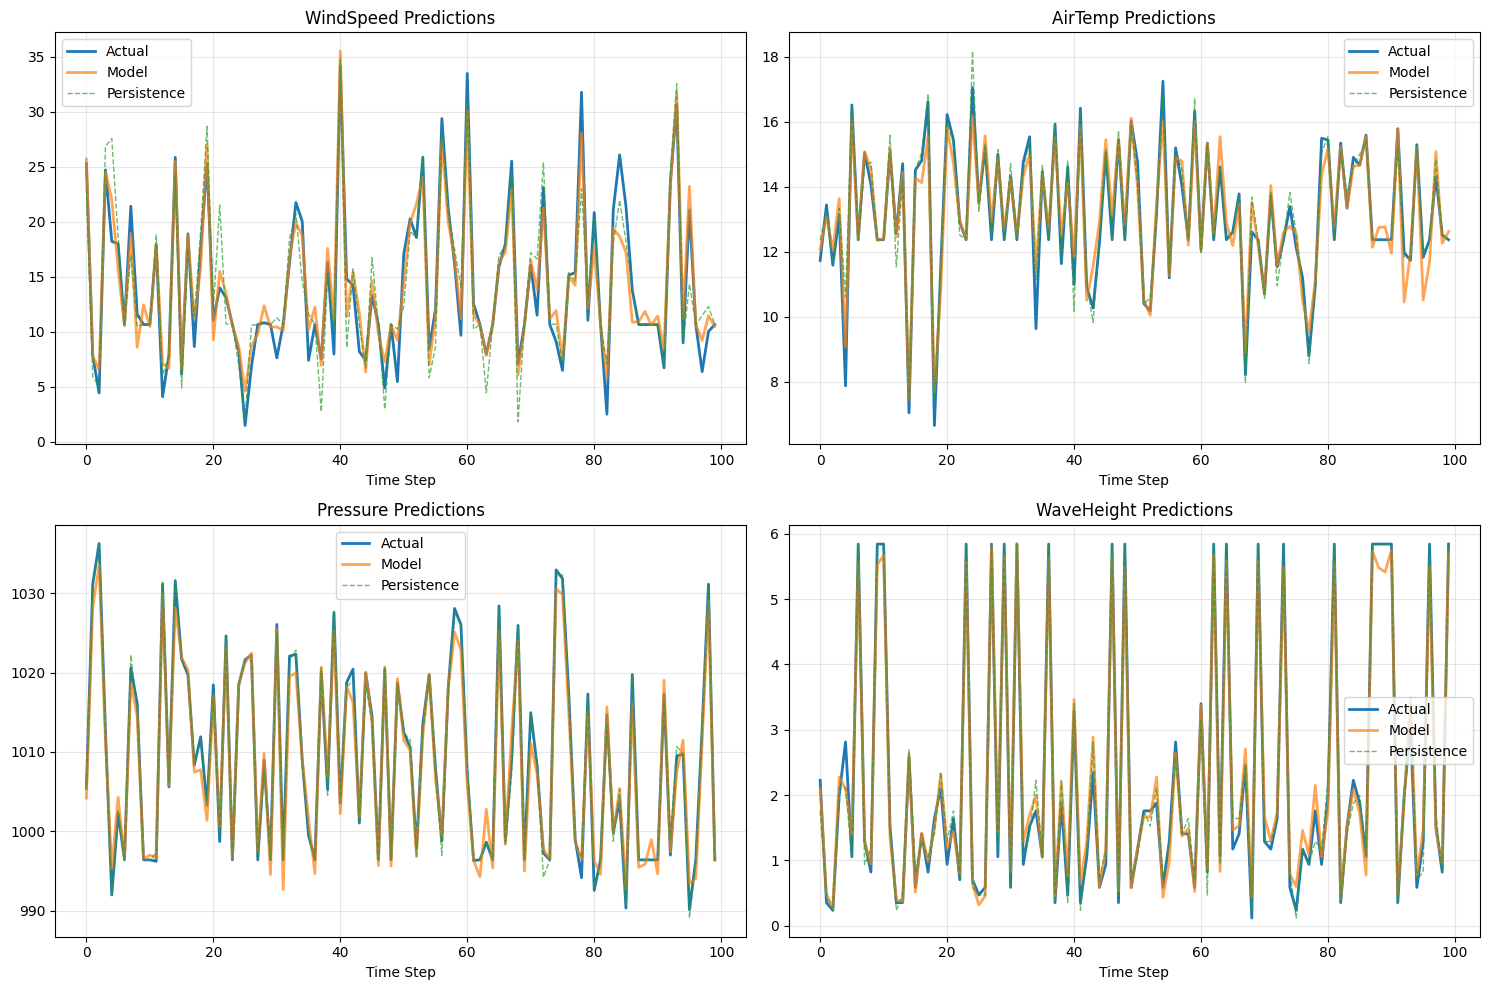

In [16]:
import matplotlib.pyplot as plt

# Plot some example predictions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

for i, (var, ax) in enumerate(zip(['WindSpeed', 'AirTemp', 'Pressure', 'WaveHeight'], axes.flat)):
    # Take first 100 predictions
    ax.plot(targets[:100, 0, i], label='Actual', linewidth=2)
    ax.plot(predictions[:100, 0, i], label='Model', linewidth=2, alpha=0.7)
    ax.plot(persistence[:100, 0, i], label='Persistence', linewidth=1, linestyle='--', alpha=0.7)
    ax.set_title(f'{var} Predictions')
    ax.set_xlabel('Time Step')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('model_predictions.png', dpi=150)
plt.show()